## AI初探-載入已訓練好的模型
在這個單元裡,我們會學習如何使用別人已經建立好的模型. 目前市場上已經有很多工具提供訓練模型的功能, 你只需要準備好資料, 就可以完成你的模型.
例如微軟的 [Custom Vision](https://azure.microsoft.com/zh-tw/services/cognitive-services/custom-vision-service/), Amazon的 [Rekognition](https://aws.amazon.com/tw/rekognition/), Google的 [AutoML](https://cloud.google.com/automl/?hl=zh-tw). 你只需要載入模型檔案就可以直接預測你的測試資料.

因為深度學習的框架不只一種, 本教學僅介紹如何使用 Keras 跟  Tensorflow 的模型檔案.

&copy; 2016 Chih-Chang Yu@CYCU MIT License

首先我們還是要載入需要的函式庫

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import load_model

## 使用Keras的模型
載入Keras模型很簡單, 只要使用 `load_model()` 函數就直接載入完成. 你可以把上一個課程訓練出來的模型拿來這邊用. 這裡我們提供了另一個模型檔案 *my_vgg_model.h5*, 對 [Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html) 資料集有比較好的辨識率, 同學可自行載入來比較兩者的不同.

註: 有時候載入模型的過程會當機, 可能的原因是有其他的 ipynb 專案佔住了 gpu 資源, 可以先從 Notebook 的首頁把其他的 process 先關掉就可以正常執行.

In [2]:
# the filepath depends on where you put your model file.
k_model = load_model('model/my_vgg_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


我們先載入類別的名稱, 之後比較好觀察辨認的結果.

In [3]:
# the filepath depends on where you put your labels file.
with open('model/labels.txt','r') as f:
        labels = (f.read().splitlines())

在使用之前, 我們得先確定模型的輸入跟輸出規範. 因此, 我們把模型的最上層(輸出)跟最底層(輸入)的結構印出來看:

In [4]:
print(k_model.layers[0].output_shape)
print(k_model.layers[-1].output_shape)  # -1 means the last layer

(None, 32, 32, 3)
(None, 10)


可以看到輸入層的結構是 32x32x3,  輸出層是 10. 因此我們必須把輸入資料先正規化成32x32x3的影像才能使用這個模型.

這邊我們還是先用cifar-10提供的的測試資料做為測試.

In [5]:
from tensorflow.keras.datasets import cifar10
(_, _),(X_test, y_test) = cifar10.load_data()

# We only normalize test data because we don't have to train a model here.
X_test = X_test/255

讀者們可以反覆執行下面的程式區塊來觀察結果.

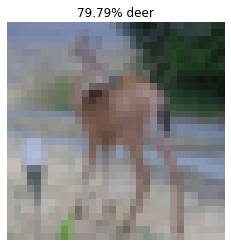

In [13]:
idx = random.randint(1,100)
im = X_test[idx]
k_output = k_model.predict(im.reshape((1,)+im.shape))
k_predict = np.argmax(k_output)
plt.imshow(im)
plt.title('{:.2f}% '.format(k_output[0][k_predict]*100) + labels[k_predict])
plt.axis('off')
plt.show()

## 使用Tensorflow的模型
由於載入 Tensorflow 模型的程式比較複雜, 我們把它包成一個函式叫做 *load_tf_model*, 這樣之後就可以直接寫 `load_tf_model()`來載入模型. 有興趣的讀者們可以自行研究一下程式碼.

In [15]:
import tensorflow as tf

In [16]:
def load_tf_model(model_filename):

    sess = tf.Session()
    with tf.gfile.FastGFile(model_filename,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def)
        
    return sess

我們一樣有提供一個結果略佳的模型 *my_vgg_model.pb* 供讀者比較

In [17]:
# call load_tf_model() to load tensorflow model.
sess = load_tf_model('model/my_vgg_model.pb')

Instructions for updating:
Use tf.gfile.GFile.


Tensorflow 比較麻煩一點, 需要用到輸入層的名稱跟輸出層的名稱才能進行預測. 我們必須先找出模型的輸入層的名稱,以及模型的輸出層的名稱. 因此我們先用下面的程式區塊印出模型中每一層的名字.  
我們要找的名稱需帶有 import 前綴字, 通常模型輸入層的名稱會有 Placeholder/input 字樣, 而輸出層會有 Softmax 字樣 (以分類問題來說).  

註: 如果當初模型是用keras來建模後轉換成tensorflow模型, 輸入層的名稱可能會有些不同, 還請讀者留意.

In [ ]:
for op in tf.get_default_graph().get_operations():
    print(str(op.name))

觀察後我們發現輸入層的名字為 `import/input`(類似), 輸出層的名字為 `output/Softmax`(類似). 在 tensorflow 中我們利用 `get_shape()` 這個函式來取得輸入/輸出的格式.

In [19]:
input_tensor = sess.graph.get_tensor_by_name('import/input:0')
softmax_tensor = sess.graph.get_tensor_by_name('import/predictions/Softmax:0')
print(input_tensor.get_shape())
print(softmax_tensor.get_shape())

(?, 32, 32, 3)
(?, 10)


以下是使用 Tensorflow 的方式進行運測. 程式碼和 keras 的版本很相似, 差別在於預測呼叫的函式不同.

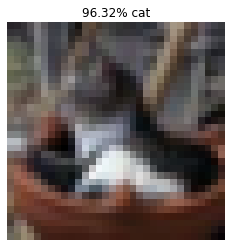

In [45]:
# randomly pick an image
idx = random.randint(1,1000)
im = X_test[idx]

# predict
softmax_tensor = sess.graph.get_tensor_by_name('import/predictions/Softmax:0')
tf_output = sess.run(softmax_tensor, {'import/input:0': im.reshape((1,)+im.shape)})
tf_predict = np.argmax(tf_output)

plt.imshow(im)
plt.title('{:.2f}% '.format(tf_output[0][tf_predict]*100) + labels[tf_predict])
plt.axis('off')
plt.show()

你也可以從網路上抓一些圖片來測試模型. Python 中提供了 `requests` 函式庫來取得網路上的資料, 因此我們便利用它來取得測試用的圖片. 這裡我們提供一些連結的圖片讓大家練習
- 飛機 https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSMxAvTYUR5hSe3Y_V-HB0XmDaG3ZcX-p-CXZaKI-7g-rZH3bCj
- 汽車 https://image.shutterstock.com/image-vector/car-cartoon-sticker-retro-style-260nw-566814880.jpg
- 青蛙 https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSJErznWjCWv70L2VudttjRkSYBiiUmo0uLgWBBNm96ftOYlnZ1kQ
- 卡車 https://target.scene7.com/is/image/Target/GUEST_5ffb9be8-fcc2-4728-87e2-cb021932896a
- 鳥 https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQRPLQBnaubH2Z2b9Bw5U0MbZGReBgqsUXPvsrJt8UwEUdqW8Yk
- 鹿 https://huntfish.mdc.mo.gov/sites/default/files/styles/species/public/images/species/deer.jpg

因為建立模型時我們是使用 32x32 的彩色圖片進行訓練, 因此取得的影像必須先把尺寸調整成 32x32 才能正確地輸入到模型. 你可以自行替換掉`get()`內的字串後執行下面的程式區塊來觀察結果.

註: 這個部分的內容(從網路取得圖片)超出了本課程的學習範疇, 因此我們不做解釋, 有興趣的同學可以自行參考一些相關資料,例如[https://blog.gtwang.org/programming/python-requests-module-tutorial/](https://blog.gtwang.org/programming/python-requests-module-tutorial/)

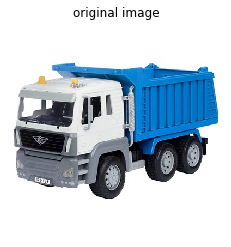

,airplaine,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


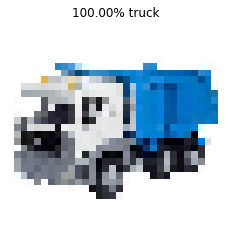

In [46]:
import pandas as pd
from IPython.display import display
from PIL import Image
from io import BytesIO
import requests

# you can get new images by replacing the string in get() function.
response = requests.get("https://target.scene7.com/is/image/Target/GUEST_5ffb9be8-fcc2-4728-87e2-cb021932896a")

if not response.ok:
    print(response)
im_data = response.content
im = Image.open(BytesIO(im_data))

plt.imshow(im)
plt.title('original image')
plt.axis('off')
plt.show()

# The input size of the image should be 32x32x3
# remember to normalize the image, use PIL library to resize it
im = im.resize((32,32))
im_arr = np.array(im)
im_arr = im_arr / 255

# use the keras model to predict
# output = k_model.predict(im_arr.reshape((1,)+im_arr.shape))

# use tensorflow model to predict
softmax_tensor = sess.graph.get_tensor_by_name('import/predictions/Softmax:0')
output = sess.run(softmax_tensor, {'import/input:0': im_arr.reshape((1,)+im_arr.shape)})

# find the largest one
predict = np.argmax(output)

# this part is just for beautiful printed texts
pd.options.display.float_format = '{:.4f}'.format
df = pd.DataFrame(output, columns=labels)
display(df)
predict = np.argmax(output)
plt.imshow(im_arr)
plt.title('{:.2f}% '.format(output[0][predict]*100) + labels[predict])
plt.axis('off')
plt.show()

### 總結
在這個單元裡, 你學習了如何載入已經訓練好的模型, 包含 Keras 以及 Tensorflow 的模型, 包括:
* 載入 Keras 模型後進行預測
* 載入 Tensorflow 模型並觀察輸入跟輸出層的名稱與資料輸入的規範
* 從網路上取得一些圖片並交由模型來預測